## The following cells are for sending and receiving data together with the project 'STAGnet_16_MxCubeApplication'. It sends tactile data to the microcontroller, which then does an inference and sends the result back

In [ ]:
import struct
import serial
import numpy as np

In [ ]:
file = 'C:/Users/fabia/Documents/Schweiz/ETH/Master/4_Semester_Spring_2020/Master_thesis/C_Code/validation_data/data2_small.csv'
# each element in 'data' corresponds to a full sensor frame
data = np.loadtxt(file, delimiter=',')

In [ ]:
preds = []
for j in range(data.shape[0]):
    ser = serial.Serial("COM3", 115200, timeout=0.5)
    for i in range(data.shape[1]):
        # '<f' means little endian format, '>f' big endian format
        packet = bytearray(struct.pack('<f', data[j][i]))
        ser.write(packet)
    read_data = ser.read(2000)
    ser.close()
    #print(read_data[0:46].decode())
    out_data = read_data[46:].decode()
    out_data = list(out_data.split('\n'))
    out_data.pop(-1)
    out_data = np.array(out_data).astype(np.int8)

    probs = []
    for i in range(len(out_data)//4):
        packet = out_data[i*4:(i+1)*4]
        unpacked = struct.unpack('<f', bytes(packet))[0]
        probs.append(unpacked)
        #print('{:f}'.format(unpacked))
    #print('\nPredicted class: {:d}'.format(np.argmax(pred)))
    preds.append(np.argmax(probs))
    # Delay so the MCU has enough time for one inference
    time.sleep(0.2)

In [ ]:
from pathlib import Path
import numpy as np
import struct
file = Path('C:/Users/fabia/Documents/Schweiz/ETH/Master/4_Semester_Spring_2020/Master_thesis/Data_Collection/test.log')
out_data = np.genfromtxt(file, delimiter='\n')
out_data = out_data.astype(np.int8)
size = len(out_data)//4

probs = []
for i in range(size):
    packet = out_data[i*4:(i+1)*4]
    unpacked = struct.unpack('<f', bytes(packet))[0]
    probs.append(unpacked)
preds = []
for i in range(size//27):
    pred = np.argmax(probs[i*27:(i+1)*27])
    preds.append(pred)
preds

In [ ]:
(len(out_data)//4)//27

In [ ]:
# Calculate accuracy
file = 'C:/Users/fabia/Documents/Schweiz/ETH/Master/4_Semester_Spring_2020/Master_thesis/C_Code/validation_data/label2_small.csv'
loaded_label = np.loadtxt(file, delimiter=',')
label = []
for i in range(loaded_label.shape[0]):
    label.append(np.argmax(loaded_label[i]))
label = np.array(label)
correct = np.count_nonzero(label == preds)
print('Accuracy {:.2f}%'.format(100*correct/len(label)))

## The following cells are for receiving a bunch of tactile data frames from the MCU in order to find statistical information about the sensor values when the STAG is unloaded

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
IMU_data = []
tactile_data = []

data_folder = Path('C:/Users/fabia/Documents/Schweiz/ETH/Master/4_Semester_Spring_2020/Master_thesis/Data_Collection')
filename = 'ball.log'
#filename = 'battery.log'
#filename = 'bracket.log'
#filename = 'coin.log'
#filename = 'empty_can.log'
#filename = 'empty_hand.log'
#filename = 'full_can.log'
#filename = 'gel.log'
#filename = 'lotion.log'
#filename = 'mug.log'
#filename = 'pen.log'
#filename = 'safety_glasses.log'
#filename = 'scissors.log'
#filename = 'screwdriver.log'
#filename = 'spray_can.log'
#filename = 'stapler.log'
#filename = 'tape.log'

with open(data_folder / filename) as f:
    # I expect data separated by \t and if it belongs to the same block. Blocks are separated by \n
    while(1):
        line = f.readline()
        if(line == ''): # reached end of file
            break
        line = line.split('\t')
        line.pop(-1) # get rid of '\n' at the end
        if(len(line) == 7): # is IMU data
            if(line[0].isdigit()):
                IMU_data.append(line)
            else:
                data_desc = line
        else: # is tactile data
            tactile_data.append(line)
            
print(len(IMU_data))
print(len(tactile_data))
IMU_data = np.array(IMU_data).astype(np.float)
tactile_data = np.array(tactile_data).astype(np.uint16)

frames = tactile_data
frames = np.reshape(frames, (len(frames),32,32))

In [ ]:
# Mask to find only the physically present sensor points
mask = np.array([np.ones(32), np.ones(32), np.ones(32),
                         np.concatenate((np.zeros(14), np.ones(18))),
                         np.concatenate((np.zeros(14), np.ones(18))),
                         np.concatenate((np.zeros(14), np.ones(18))),
                         np.ones(32), np.ones(32), np.ones(32),
                         np.concatenate((np.zeros(14), np.ones(18))),
                         np.ones(32), np.ones(32), np.ones(32),
                         np.concatenate((np.zeros(14), np.ones(18))),
                         np.concatenate((np.zeros(14), np.ones(18))),
                         np.ones(32), np.ones(32), np.ones(32),
                         np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                         np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                         np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                         np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                         np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                         np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                         np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                         np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                         np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                         np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                         np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                         np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                         np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                         np.concatenate((np.zeros(25), np.ones(4), np.zeros(3)))]).astype(np.bool)
#mask = np.transpose(mask)

#phys_frames = frames[:, mask]
#unphys_frames = frames[:, np.logical_not(mask)]
plt.imshow(np.logical_not(mask))

In [ ]:
all_data = np.mean(np.reshape(frames, (len(frames), 1024)), 0)
all_data.sort()
phys_data = np.mean(phys_frames, 0)
phys_data.sort()
unphys_data = np.mean(unphys_frames, 0)
unphys_data.sort()

pdf_all = stats.norm.pdf(all_data, np.mean(all_data), np.std(all_data))
plt.figure(figsize=(10,6))
plt.hist(all_data, density=True, bins=20)
plt.plot(all_data, pdf_all)
plt.grid()
#plt.xlim([1820, 2010])
plt.show()

pdf_phys = stats.norm.pdf(phys_data, np.mean(phys_data), np.std(phys_data))
plt.figure(figsize=(10,6))
plt.hist(phys_data, density=True, bins=20)
plt.plot(phys_data, pdf_phys)
plt.grid()
#plt.xlim([1820, 2010])
plt.show()

pdf_unphys = stats.norm.pdf(unphys_data, np.mean(unphys_data), np.std(unphys_data))
plt.figure(figsize=(10,6))
plt.hist(unphys_data, density=True, bins=16)
plt.plot(unphys_data, pdf_unphys)
plt.grid()
#plt.xlim([1825, 2010])
plt.show()

## The following cells are for visualizing the data that was collected with the 'STAG_test_DataLogging' application

In [22]:
import numpy as np
import pyqtgraph as pg
from pathlib import Path
from pyqtgraph.Qt import QtCore, QtGui
import matplotlib.pyplot as plt
import pandas as pd

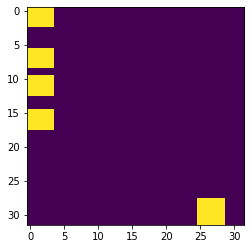

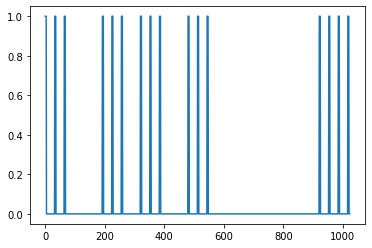

In [24]:
# Mask to find only the physically present sensor points
mask = np.array([np.ones(32), np.ones(32), np.ones(32), # pinky
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.ones(32), np.ones(32), np.ones(32), # ring
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.ones(32), np.ones(32), np.ones(32), # middle
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.ones(32), np.ones(32), np.ones(32), # index
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3)))]).astype(np.bool)

# Mask to find only the finger tips
finger_mask = np.zeros((32,32))
finger_mask[:, 0:4] = 1
finger_mask[28:32, :] = 1
finger_mask = np.logical_and(finger_mask, mask)
plt.imshow(finger_mask)
plt.show()
finger_mask = finger_mask.reshape((1024,))
plt.plot(finger_mask)
plt.show()

In [26]:
IMU_data = []
tactile_data = []

#data_folder = Path('C:/Users/fabia/Documents/Schweiz/ETH/Master/4_Semester_Spring_2020/Master_thesis/Data_Collection/3kOhm_FB/Recording_session_00')
#filenames = ['ball.log', 'battery.log', 'bracket.log', 'coin.log', 'empty_can.log', 'empty_hand.log', 'full_can.log', 'gel.log', 'lotion.log', 'mug.log', 'pen.log', 'safety_glasses.log', 'scissors.log', 'screwdriver.log', 'spray_can.log', 'stapler.log', 'tape.log']
#data_folder = Path('C:/Users/fabia/Documents/Schweiz/ETH/Master/4_Semester_Spring_2020/Master_thesis/Data_Collection/3kOhm_FB/Temporal_sequences/Movement_direction')
#filenames = ['ball_N.log', 'ball_NE.log', 'ball_E.log', 'ball_SE.log', 'ball_S.log', 'ball_SW.log', 'ball_W.log', 'ball_NW.log']
#data_folder = Path('C:/Users/fabia/Documents/Schweiz/ETH/Master/4_Semester_Spring_2020/Master_thesis/Data_Collection/3kOhm_FB/Temporal_sequences/Contact_detection')
#filenames = ['lotion_contact.log']
data_folder = Path('C:/Users/fabia/Documents/Schweiz/ETH/Master/4_Semester_Spring_2020/Master_thesis/Data_Collection/3kOhm_FB/Temporal_sequences/Slip_detection')
filenames = ['lotion_slip.log']

with open(data_folder / filenames[0]) as f:
    # I expect data separated by \t and if it belongs to the same block. Blocks are separated by \n
    while(1):
        line = f.readline()
        if(line == ''): # reached end of file
            break
        line = line.split('\t')
        line.pop(-1) # get rid of '\n' at the end
        if(len(line) == 7): # is IMU data
            if(line[0].isdigit()):
                IMU_data.append(line)
            else:
                data_desc = line
        else: # is tactile data
            line.pop(0)
            tactile_data.append(line)
            
print(len(IMU_data))
print(len(tactile_data))
if(len(IMU_data) != 0):
    IMU_data = np.array(IMU_data).astype(np.int16)
tactile_data = np.array(tactile_data).astype(np.uint16)

0
700


(700, 64)


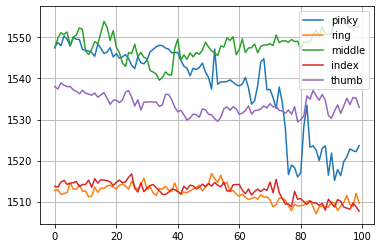

In [44]:
# Extract data from the fingertips
tac_fingertips = tactile_data[:, finger_mask]
print(tac_fingertips.shape)
# The first 12 values are pinky, second 12 ring, ... last 16 are thumb
pinky = np.mean(tac_fingertips[:, 0:12], axis=1)
ring = np.mean(tac_fingertips[:, 12:24], axis=1)
middle = np.mean(tac_fingertips[:, 24:36], axis=1)
index = np.mean(tac_fingertips[:, 36:48], axis=1)
thumb = np.mean(tac_fingertips[:, 48:64], axis=1)

i = 6
plt.plot(pinky[i*100:(i+1)*100])
plt.plot(ring[i*100:(i+1)*100])
plt.plot(middle[i*100:(i+1)*100])
plt.plot(index[i*100:(i+1)*100])
plt.plot(thumb[i*100:(i+1)*100])
plt.legend(['pinky', 'ring', 'middle', 'index', 'thumb'])
plt.grid()
plt.show()

In [ ]:
# Interpret image data as row-major instead of col-major
pg.setConfigOptions(imageAxisOrder='row-major')

app = QtGui.QApplication([])

## Create window with ImageView widget
win = QtGui.QMainWindow()
win.resize(800,800)
imv = pg.ImageView()
win.setCentralWidget(imv)
win.show()
win.setWindowTitle('Tactile data')

data = tactile_data.reshape((-1, 32, 32))

## Display the data and assign each frame a time value from 0.0 to 2.0
imv.setImage(data, xvals=np.linspace(0., data.shape[0]/100, data.shape[0]))

## Set a custom color map
colors = [
    (0, 0, 0),
    (45, 5, 61),
    (84, 42, 55),
    (150, 87, 60),
    (208, 171, 141),
    (255, 255, 255)
]
cmap = pg.ColorMap(pos=np.linspace(0.0, 1.0, 6), color=colors)
imv.setColorMap(cmap)

In [ ]:
QtGui.QApplication.instance().exec_()

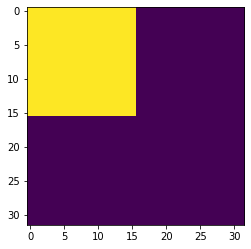

In [45]:
import matplotlib.pyplot as plt
import numpy as np

mask = np.zeros((32,32))
mask[0:16, 0:16] = 1
plt.imshow(mask)
plt.show()

## The following cells are for comparing frames from different recording sessions and visualizing operations such as gaussian blurring on the frames

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.ndimage import gaussian_filter

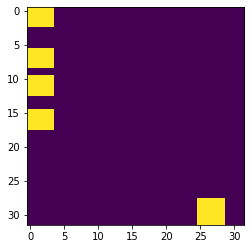

In [21]:
# Mask to find only the physically present sensor points
mask = np.array([np.ones(32), np.ones(32), np.ones(32), # pinky
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.ones(32), np.ones(32), np.ones(32), # ring
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.ones(32), np.ones(32), np.ones(32), # middle
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.concatenate((np.zeros(14), np.ones(18))),
                 np.ones(32), np.ones(32), np.ones(32), # index
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3))),
                 np.concatenate((np.zeros(25), np.ones(4), np.zeros(3)))]).astype(np.bool)

# Mask to find only the finger tips
finger_mask = np.zeros((32,32))
finger_mask[:, 0:4] = 1
finger_mask[28:32, :] = 1
finger_mask = np.logical_and(finger_mask, mask)
plt.imshow(finger_mask)
plt.show()

In [15]:
filename = Path('C:/Users/fabia/Documents/Schweiz/ETH/Master/4_Semester_Spring_2020/Master_thesis/Data_Collection/3kOhm_FB/data_MT_FabianGeiger_4sess.mat')

data = sio.loadmat(filename, squeeze_me=True)
# Use only frames in which objects were touched
valid_mask = data['valid_flag'] == 1
pressure = data['tactile_data'][valid_mask]
# Scale data to the range [0, 1]
pressure = np.clip((pressure.astype(np.float32)-1500)/(2700-1500), 0.0, 1.0)
pressure = np.reshape(pressure, (-1, 32, 32))
#pressure = np.exp2(pressure)
for press in pressure:
    mean_p = np.mean(press[mask])
    boost_mask = press > mean_p
    press[boost_mask] = list(map(lambda x: 4*(x-mean_p), press[boost_mask]))
object_id = data['object_id'][valid_mask]

num_sessions = len(np.unique(data['session_id']))
x = []
y = []
valid_sessions = data['session_id'][valid_mask]
for i in range(num_sessions):
    session_mask = valid_sessions == i
    x.append(pressure[session_mask])
    y.append(object_id[session_mask])

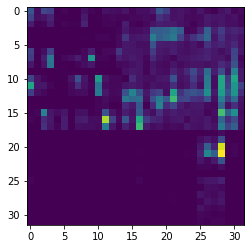

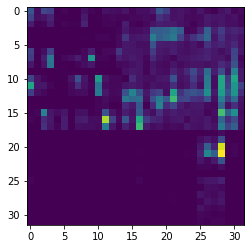

In [16]:
pressure_clipped = np.clip(pressure, 0.0, 1.0)
idx = 1000
plt.imshow(pressure[idx])
plt.show()
plt.imshow(pressure_clipped[idx])
plt.show()

In [ ]:
# Find closest frames for a certain frame
# idx = -1
# min_dist = 100
# comp_idx = 40000
# frame1 = x[0][comp_idx]
# for i, frame2 in enumerate(x[1]):
#     dist = np.linalg.norm(frame1 - frame2)
#     if(dist < min_dist):
#         min_dist = dist
#         idx = i

# print('Class', y[0][comp_idx])
# plt.imshow(frame1.reshape((32,32)))
# plt.show()
# print('Index', idx, 'and class', y[1][idx])
# plt.imshow(x[1][idx].reshape((32,32)))
# plt.show()

sess0_mean = np.mean(x[0], axis=0).reshape((32,32))
plt.imshow(sess0_mean)
plt.show()
sess1_mean = np.mean(x[1], axis=0).reshape((32,32))
plt.imshow(sess1_mean)
plt.show()

In [ ]:
frame1_

frame1_filtered = gaussian_filter(frame1.reshape((32,32)), sigma=0.6)

frame1_filtered[~mask] = 0.0
plt.imshow(frame1_filtered)
plt.show()

## The following cells are for checking the number of frames per class

In [ ]:
import scipy.io as sio
from pathlib import Path
import numpy as np

In [ ]:
filename = Path('C:/Users/fabia/Documents/Schweiz/ETH/Master/4_Semester_Spring_2020/Master_thesis/Data_Collection/3kOhm_FB/data_MT_FabianGeiger_4sess.mat')

data = sio.loadmat(filename, squeeze_me=True)
print('Total frames:', len(data['object_id']))
# Use only frames in which objects were touched
valid_mask = data['valid_flag'] == 1
object_id = data['object_id'][valid_mask]
print('Valid frames:', len(object_id))

min_n = len(object_id)
idx = 0
for obj_id in range(len(data['objects'])):
    obj_mask = object_id == obj_id
    n = np.count_nonzero(obj_mask)
    if(n < min_n):
        print('SIKE!')
        min_n = n
        idx = obj_id
print('Minimum number of frames:', min_n, 'for object', data['objects'][idx])